<a href="https://colab.research.google.com/github/microprediction/timeseries-notebooks/blob/main/neuralprophet_hello.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install neuralprophet strangely fails in colab
!pip install git+https://github.com/ourownstory/neural_prophet.git
import logging, sys
logging.disable(sys.maxsize)

In [ ]:
!pip install microprediction

### Hello world univariate prediction example
See https://www.microprediction.com/blog/popular-timeseries-packages for more packages

In [48]:
from microprediction import MicroReader
mr = MicroReader()
YS = mr.get_lagged_values(name='emojitracker-twitter-face_with_medical_mask.json')[:500]
# or pick from https://www.microprediction.org/browse_streams.html

### Simple example. Mess with this for quick debugging

In [49]:
# A simple example to make it easier to debug directly in colab 
DF = pd.DataFrame(columns=['y'],data=YS)
DF['ds'] = pd.date_range(start='2021-01-01', periods=len(YS), freq='5min')
DF[:4]

model = NeuralProphet(
    n_lags=4,
    changepoints_range=0.95,
    n_changepoints=30,
    weekly_seasonality=False,
    batch_size=64,
    epochs=10,
    learning_rate=1.0,
)
metrics = model.fit(DF, freq='5min')
FUTURE = model.make_future_dataframe(DF,periods=1)
FORECAST = model.predict(FUTURE)
FORECAST['yhat1'].values[-1]

Epoch[10/10]: 100%|██████████| 10/10 [00:00<00:00, 31.43it/s, SmoothL1Loss=0.0205, MAE=2.82, RegLoss=0]


8.712859153747559

### Example of periodically fitting and predicting an entire time series out of sample 

In [57]:
# Some key params to mess with
N_LAGS = 12
N_CHANGEPOINTS = 4

In [ ]:
from neuralprophet import NeuralProphet
import pandas as pd 
import datetime 

def prophet_next(ys:[float],model=None):
    """ Predict the next point in a series
             
          returns y_hat, new model 
    """
    if len(ys)==0:
      return 0.0, None 
    if len(ys)<400:
       return ys[-1], None 
    if model is None or len(ys) % 17 ==0: 
      # Periodically fit
      model = NeuralProphet(
          n_lags=N_LAGS,
          changepoints_range=0.95,
          n_changepoints=N_CHANGEPOINTS,
          weekly_seasonality=False,
          batch_size=64,
          epochs=10,
          learning_rate=1.0,
      )
    # Predict out of sample
    # Shouldn't be reconstructing each step but who cares? 
    df = pd.DataFrame(columns=['y'],data=ys)
    df['ds'] = pd.date_range(start='2021-01-01', periods=len(ys), freq='5min')
    metrics = model.fit(df, freq='5min')
    future = model.make_future_dataframe(df, periods=1)
    forecast = model.predict(future)
    y_hat = forecast['yhat1'].values[-1]
    print('y_hat = '+str(y_hat))
    return y_hat, model
   
def predict_all(ys:[float])->[float]:
  """ Predict using periodic refitting 

      ys:       observations
      returns:  priors    (i.e. out of sample)
  
  """
  model = None 
  y_hats = list()
  for t in range(len(ys)-1):
     y_hat, model = prophet_next(ys[:t],model)
     y_hats.append(y_hat)
  return y_hats 

XS = predict_all(YS)

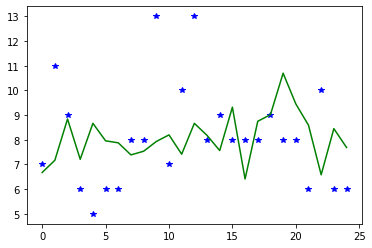

In [59]:
import matplotlib.pyplot as plt
plt.plot(YS[474:499],'*b')
plt.plot(XS[474:499],'g')